## Trend analysis

In [2]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable




In [3]:
import utils.load_grid as lg
from utils.load_cmaps import *

In [4]:
pgrid_dir = "data/article_data/jgr_grid_final"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

In [5]:
# Helpfiles
helps, hvars = lg.load_helpfiles(cases)

# Configuration variables
cvars = lg.load_cvars(cases)

print("Done")

Helpfiles:   0%|          | 0/1029 [00:00<?, ?it/s]

Configs: 100%|██████████| 1029/1029 [00:03<00:00, 269.20it/s]

Done


## Variable1 vs VMR

In [6]:
def trend_vmr(metric, metric_lbl, control):

    fig,ax = plt.subplots(figsize=(8,6))

    for vol in lg.volatile_species:
        xs = []
        ys = []
        for i in range(ncases):
            skip_this = False
            for k in control.keys():
                if k in cvars.keys():
                    if not np.isclose(cvars[k][i],control[k]):
                        skip_this = True
                        break
            if not skip_this:
                xs.append(lg.access_hvars(hvars,vol+"_mr",-1)[i])
                ys.append(lg.access_hvars(hvars,metric,-1)[i])
        mask = np.argsort(xs)
        xs = np.array(xs)[mask] * 100.0
        ys = np.array(ys)[mask]

        ax.plot(xs,ys, label=vol, color=lg.volatile_colors[vol])

    ax.set_xlabel("Volume mixing ratio [%]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel(metric_lbl)
    ax.legend()
    plt.show()

In [7]:
control = {
    "CH_ratio":1.0
}

trend_vmr("Time", "Termination time [yr]", control)

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 800x600 with 1 Axes>

## Variable1 vs Variable2 scatter plot

In [8]:
def trend_any(x,x_lbl, y,y_lbl, control, logx=False, logy=False):

    fig,ax = plt.subplots(figsize=(6,5))

    xs = []
    ys = []
    cs = []
    for i in range(ncases):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if not skip_this:
            xs.append(lg.access_hvars(hvars,x,-1)[i])
            ys.append(lg.access_hvars(hvars,y,-1)[i])
            if lg.access_hvars(hvars,"Phi_global",-1)[i] < 0.1:
                color='black'
            else:
                color='orange'
            cs.append(color)
    mask = np.argsort(xs)
    xs = np.array(xs)[mask]
    ys = np.array(ys)[mask]
    cs = np.array(cs)[mask]

    ax.scatter(xs,ys, color=cs, s=20)

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    plt.show()

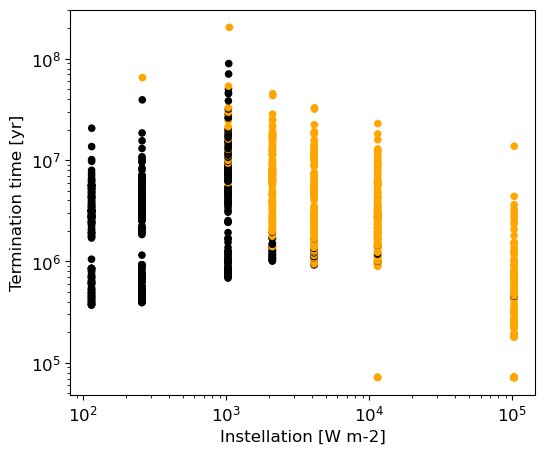

In [22]:
trend_any(
    "F_ins", "Instellation [W m-2]", 
    "Time", "Termination time [yr]",
    control={},
    logx=True,
    logy=True
)

## Variable1 vs P_surf,T_surf map

In [20]:
def map_pt(z_key,z_lbl, control, logz=False):

    fig,ax = plt.subplots(figsize=(6,5))

    xs = []
    ys = []
    zs = []
    for i in range(ncases):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if not skip_this:
            xs.append(lg.access_hvars(hvars,"T_surf",-1)[i])
            ys.append(lg.access_hvars(hvars,"P_surf",-1)[i])
            zs.append(lg.access_hvars(hvars,z_key   ,-1)[i])
    mask = np.argsort(xs)
    xs = np.array(xs)[mask]
    ys = np.array(ys)[mask]
    zs = np.array(zs)[mask]

    if not logz:
        norm = mpl.colors.Normalize(vmin=np.amin(zs), vmax=np.amax(zs))
    else:
        norm = mpl.colors.LogNorm(vmin=np.amin(zs), vmax=np.amax(zs))
    cmap = sci_colormaps['batlow']
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    ax.scatter(xs,ys, c=zs, s=20, cmap=cmap, norm=norm)

    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    fig.colorbar(sm, cax=cax, orientation='vertical').set_label(z_lbl) 

    ax.set_xlabel("Surface temperature [K]")
    ax.set_ylabel("Surface pressure [bar]")
    plt.show()

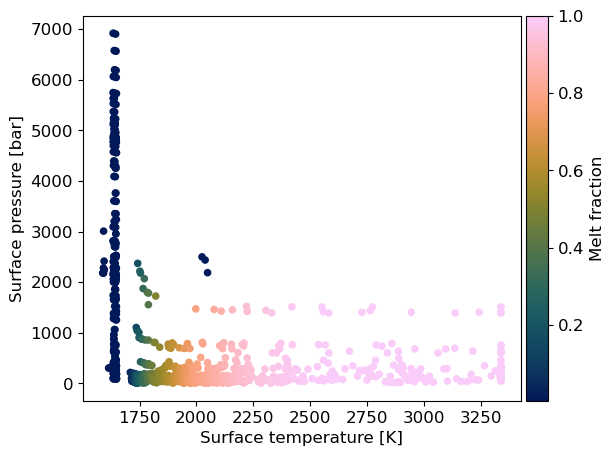

In [34]:
control = {}

z_key = "Phi_global"
z_lbl = "Melt fraction"

map_pt(z_key,z_lbl, control, logz=False)